Epoch 1, Loss: 0.00175
Epoch 2, Loss: 0.00171
Epoch 3, Loss: 0.00166
Epoch 4, Loss: 0.00161
Epoch 5, Loss: 0.00157
Epoch 6, Loss: 0.00153
Epoch 7, Loss: 0.00149
Epoch 8, Loss: 0.00146
Epoch 9, Loss: 0.00142
Epoch 10, Loss: 0.00138
Epoch 11, Loss: 0.00134
Epoch 12, Loss: 0.00131
Epoch 13, Loss: 0.00127
Epoch 14, Loss: 0.00123
Epoch 15, Loss: 0.00119
Epoch 16, Loss: 0.00115
Epoch 17, Loss: 0.00110
Epoch 18, Loss: 0.00106
Epoch 19, Loss: 0.00102
Epoch 20, Loss: 0.00098
Epoch 21, Loss: 0.00094
Epoch 22, Loss: 0.00091
Epoch 23, Loss: 0.00086
Epoch 24, Loss: 0.00082
Epoch 25, Loss: 0.00079
Epoch 26, Loss: 0.00076
Epoch 27, Loss: 0.00073
Epoch 28, Loss: 0.00070
Epoch 29, Loss: 0.00067
Epoch 30, Loss: 0.00064
Epoch 31, Loss: 0.00061
Epoch 32, Loss: 0.00059
Epoch 33, Loss: 0.00057
Epoch 34, Loss: 0.00056
Epoch 35, Loss: 0.00054
Epoch 36, Loss: 0.00052
Epoch 37, Loss: 0.00051
Epoch 38, Loss: 0.00049
Epoch 39, Loss: 0.00048
Epoch 40, Loss: 0.00047
Epoch 41, Loss: 0.00046
Epoch 42, Loss: 0.00045
E

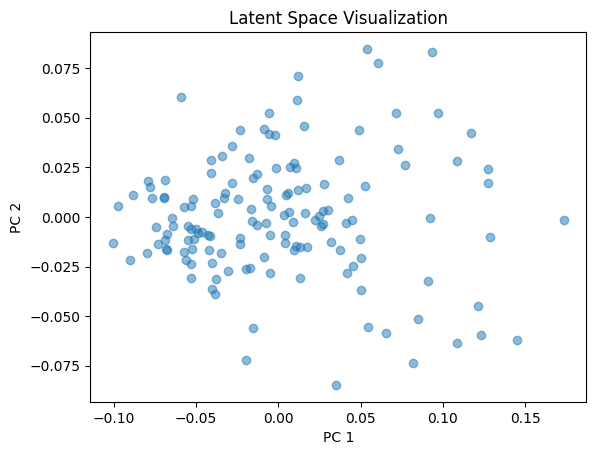

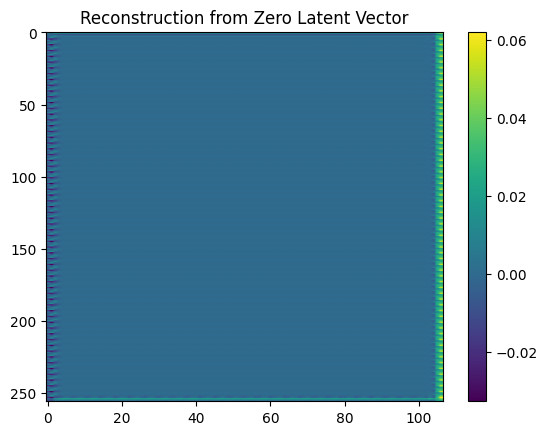

Reconstruction shape: torch.Size([16, 1, 256, 107])
Reconstruction min: -0.04432852938771248, max: 0.07113277167081833, mean: 0.001075927633792162


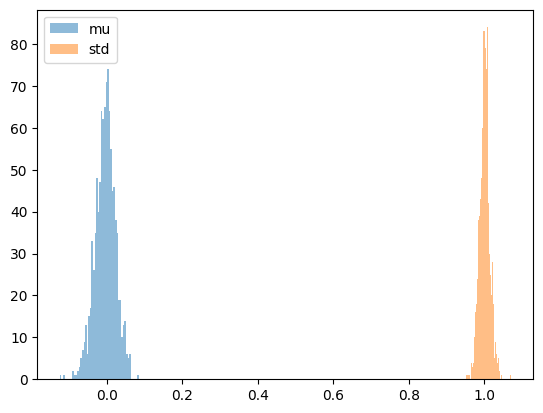

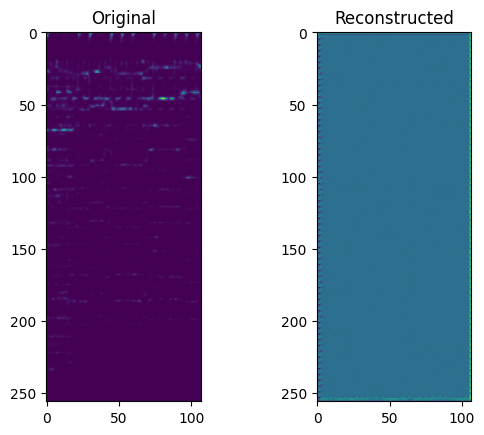

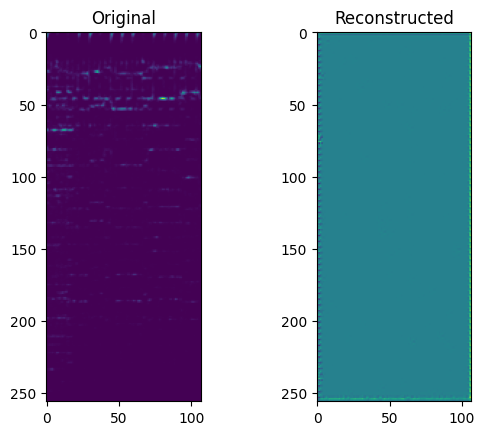

Saved: source_0.wav
Saved: source_1.wav


In [3]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
import numpy as np
import os
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch.nn.functional as F

# ============================
# Data Preprocessing
# ============================
class AudioDataset(Dataset):
    def __init__(self, file_list, sample_rate=16000, downsample_rate=8000, n_fft=2048, hop_length=512, n_mels=256):
        self.file_list = file_list
        self.sample_rate = sample_rate
        self.downsample_rate = downsample_rate
        self.default_n_fft = n_fft  # Save default n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.file_list[idx])

        # Downsample
        if sr != self.downsample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.downsample_rate)
            waveform = resampler(waveform)

        # Convert to mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Determine appropriate n_fft
        signal_length = waveform.size(1)
        n_fft = min(self.default_n_fft, signal_length)

        # Create MelSpectrogram transform
        transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.downsample_rate,
            n_fft=n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels
        )

        # Compute Mel-Spectrogram
        mel_spectrogram = transform(waveform).squeeze(0)  # Shape: (n_mels, time_frames)

        # Normalize spectrogram
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.min()) / (mel_spectrogram.max() - mel_spectrogram.min() + 1e-6)

        return mel_spectrogram

class SymmetricEncoder(nn.Module):
    def __init__(self, input_channels=1, latent_dim=64):
        super(SymmetricEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),  # 1/2
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 1/4
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 1/8
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * (input_dim[0] // 8) * (input_dim[1] // 8), latent_dim * 2)  # Mu and logvar
        )

    def forward(self, x):
        return self.encoder(x)

class SymmetricDecoder(nn.Module):
    def __init__(self, latent_dim=64, output_shape=(256, 107)):
        super(SymmetricDecoder, self).__init__()
        self.output_shape = output_shape
        self.latent_dim = latent_dim
        intermediate_dims = 128 * (output_shape[0] // 8) * (output_shape[1] // 8)
        self.fc = nn.Linear(latent_dim, intermediate_dims)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # x2
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # x4
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # x8
            nn.Tanh()  # Match normalized spectrogram range
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 128, self.output_shape[0] // 8, self.output_shape[1] // 8)
        return self.decoder(x)

class SpectrogramRefiner(nn.Module):
    def __init__(self):
        super(SpectrogramRefiner, self).__init__()
        self.refiner = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.refiner(x)


# ============================
# Variational Autoencoder
# ============================
class VAE(nn.Module):
    def __init__(self, input_dim=(256, 107), latent_dim=64):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.refiner = SpectrogramRefiner()

        # Flatten input dynamically
        flat_dim = input_dim[0] * input_dim[1]

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(flat_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # Output mean and log-variance
        )

        # Decoder
        # self.decoder = nn.Sequential(
        #     nn.Linear(latent_dim, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 1024),
        #     nn.ReLU(),
        #     nn.Linear(1024, flat_dim),
        #     nn.Tanh()  # Match normalized spectrogram range [0, 1]
        # )

        # Decoder
        self.decoder = ConvDecoder(latent_dim, input_dim)

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    # def decode(self, z):
    #     flat_output = self.decoder(z)
    #     print(f"Decoder output shape: {flat_output.shape}")
    #     output = flat_output.view(-1, *self.input_dim)
    #     return output / output.abs().max(dim=-1, keepdim=True)[0].clamp(min=1e-6)

    def decode(self, z):
        x = self.decoder(z)
        x = self.refiner(x)
        return x


    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# def vae_loss(recon_x, x, mu, logvar, beta=0.1, epsilon=1e-6):
#     # Reconstruction Loss (L1)
#     recon_loss = F.l1_loss(recon_x, x, reduction='sum')
    
#     # KL Divergence
#     kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp().clamp(min=epsilon))
    
#     # Weighted Loss
#     total_loss = recon_loss + beta * kl_div
#     # print(f"Reconstruction Loss: {recon_loss.item()}, KL Divergence: {kl_div.item()}, Beta: {beta}")
#     return total_loss
def vae_loss(recon_x, x, mu, logvar, kl_weight=1.0, epsilon=1e-6):
    recon_loss = F.l1_loss(recon_x.squeeze(1), x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp().clamp(min=epsilon))
    latent_regularization = torch.mean((mu.abs() - 0.5).clamp(min=0))  # Encourage usage of latent space
    return recon_loss + kl_weight * kl_div + 0.01 * latent_regularization


# ============================
# Self-Supervised Pretraining (A-MAE)
# ============================
class MaskedAutoencoder(nn.Module):
    def __init__(self, input_dim, mask_ratio=0.8):
        super(MaskedAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.mask_ratio = mask_ratio
        self.flat_dim = input_dim[0] * input_dim[1]

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.flat_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, self.flat_dim),
            nn.Tanh()
        )

    def forward(self, x):
        # Randomly mask input
        mask = torch.rand(x.size()) > self.mask_ratio
        masked_x = x * mask

        # Encode and decode
        z = self.encoder(masked_x.view(masked_x.size(0), -1))
        recon_x = self.decoder(z).view(x.size())
        return recon_x, mask

def mae_loss(recon_x, x, mask, epsilon=1e-6):
    # Only calculate loss for masked regions
    valid_elements = mask.sum() + epsilon  # Avoid division by zero
    loss = F.l1_loss(recon_x * mask, x * mask, reduction='sum') / valid_elements
    return loss

# ============================
# Training Loop
# ============================
def train_model(model, dataloader, optimizer, loss_fn, epochs, device):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        kl_weight = min(1.0, epoch / 50)  # Gradually increase KL weight over 10 epochs
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)

            # Handle loss based on model type
            if isinstance(model, VAE):
                recon_x, mu, logvar = output
                loss = loss_fn(recon_x, batch, mu, logvar, kl_weight)
            elif isinstance(model, MaskedAutoencoder):
                recon_x, mask = output
                loss = loss_fn(recon_x, batch, mask)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader.dataset):.5f}")

# ============================
# Clustering and Source Reconstruction
# ============================
def cluster_latent_representations(latent_vectors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(latent_vectors)
    centroids = kmeans.cluster_centers_
    return clusters, centroids

def reconstruct_sources(vae, centroids, device):
    vae.eval()
    centroids = torch.tensor(centroids, dtype=torch.float32).to(device)
    with torch.no_grad():
        reconstructed_sources = vae.decode(centroids).view(-1, *vae.input_dim)
        # Denormalize reconstructed spectrograms
        reconstructed_sources = (reconstructed_sources + 1) / 2  # Scale back to [0, 1]
    return reconstructed_sources


# ============================
# Example Usage
# ============================
if __name__ == "__main__":
    # Parameters
    # Define the folder containing the audio files
    folder_path = "ground_truth_others"

    # Get a list of all .wav files in the folder
    file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.wav')]

    dataset = AudioDataset(file_list)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Adjust dataset initialization
    sample_data = next(iter(dataloader))  # Load a single batch
    input_dim = sample_data[0].shape[-2:]  # (n_mels, time_frames)

    # Pretrain with A-MAE
    mae = MaskedAutoencoder(input_dim=input_dim)
    mae_optimizer = torch.optim.Adam(mae.parameters(), lr=1e-5)
    train_model(mae, dataloader, mae_optimizer, mae_loss, epochs=100, device=device)

    # Train VAE
    vae = VAE(input_dim=input_dim, latent_dim=64)
    vae_optimizer = torch.optim.Adam(vae.parameters(), lr=1e-5)
    train_model(vae, dataloader, vae_optimizer, vae_loss, epochs=100, device=device)

    # Initialize weights
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    # Apply weight initialization
    mae.apply(init_weights)
    vae.apply(init_weights)


    # Extract Latent Representations
    latent_vectors = []
    for batch in dataloader:
        batch = batch.to(device)
        with torch.no_grad():
            mu, _ = vae.encode(batch.view(batch.size(0), -1))
            mu = mu.cpu().numpy()
            mu = np.nan_to_num(mu, nan=0.0)  # Replace NaN values with 0
            latent_vectors.append(mu)
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    
    # Visualize with PCA
    pca = PCA(n_components=2)
    reduced_latent = pca.fit_transform(latent_vectors)

    plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], alpha=0.5)
    plt.title("Latent Space Visualization")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.show()

    # Test decoder with simple latent vectors
    test_latent = torch.zeros((1, vae.latent_dim)).to(device)  # All zeros
    with torch.no_grad():
        recon_test = vae.decode(test_latent).cpu().numpy()

    plt.imshow(recon_test[0].squeeze(), aspect='auto', cmap='viridis')
    plt.title("Reconstruction from Zero Latent Vector")
    plt.colorbar()
    plt.show()

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            mu, logvar = vae.encode(batch.view(batch.size(0), -1))
            recon = vae.decode(mu)
            
            print(f"Reconstruction shape: {recon.shape}")
            print(f"Reconstruction min: {recon.min()}, max: {recon.max()}, mean: {recon.mean()}")
            
            if recon.numel() == 0:
                print("Decoded signal is empty!")
            break  # Analyze one batch only


    for batch in dataloader:
        batch = batch.to(device)
        mu, logvar = vae.encode(batch.view(batch.size(0), -1))
        # print(f"mu min: {mu.min()}, mu max: {mu.max()}, mu mean: {mu.mean()}")
        # print(f"logvar min: {logvar.min()}, logvar max: {logvar.max()}, logvar mean: {logvar.mean()}")
        # break  # Analyze one batch only
        plt.hist(mu.cpu().detach().numpy().flatten(), bins=50, alpha=0.5, label='mu')
        plt.hist(torch.exp(0.5 * logvar).cpu().detach().numpy().flatten(), bins=50, alpha=0.5, label='std')
        plt.legend()
        plt.show()
        break


    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            recon, mu, logvar = vae(batch)
            plt.subplot(1, 2, 1)
            plt.title("Original")
            plt.imshow(batch[0].cpu().numpy())
            plt.subplot(1, 2, 2)
            plt.title("Reconstructed")
            plt.imshow(recon[0].squeeze().cpu().numpy())
            plt.show()
            break

    with torch.no_grad():
        mu, _ = vae.encode(batch.view(batch.size(0), -1))
        recon = vae.decode(mu).cpu()
        plt.subplot(1, 2, 1)
        plt.title("Original")
        plt.imshow(batch[0].cpu().numpy())
        plt.subplot(1, 2, 2)
        plt.title("Reconstructed")
        plt.imshow(recon[0].squeeze().cpu().numpy())
        plt.show()

    # with torch.no_grad():
    #     recon = vae.decode(mu).cpu()
    #     diff = (batch[0].cpu().numpy() - recon[0].cpu().numpy())
    #     plt.subplot(1, 3, 1)
    #     plt.title("Original")
    #     plt.imshow(batch[0].cpu().numpy())
    #     plt.subplot(1, 3, 2)
    #     plt.title("Reconstructed")
    #     plt.imshow(recon[0].squeeze().cpu().numpy())
    #     plt.subplot(1, 3, 3)
    #     plt.title("Difference")
    #     plt.imshow(diff)
    #     plt.show()



    assert not np.any(np.isnan(latent_vectors)), "NaN values found in latent vectors after imputation."
    assert latent_vectors.shape[1] > 0, "Latent vectors have no features for clustering."

    # Clustering and Reconstruction
    num_clusters = 2  # Example: Separate into 2 sources
    clusters, centroids = cluster_latent_representations(latent_vectors, num_clusters)
    reconstructed_sources = reconstruct_sources(vae, centroids, device=device)

    import librosa
import torch

def stretch_signal(waveform, original_length, target_length, sample_rate=8000):
    """
    Stretches the signal to match the target length using Librosa's time-stretching.
    """
    # Convert to numpy
    waveform_np = waveform.cpu().numpy().squeeze()

    # Calculate the stretch factor
    stretch_factor = target_length / original_length

    # Perform time-stretching
    stretched_waveform = librosa.effects.time_stretch(waveform_np, rate=stretch_factor)

    # Convert back to tensor and reshape
    stretched_waveform = torch.tensor(stretched_waveform, dtype=waveform.dtype).unsqueeze(0)

    return stretched_waveform

import librosa
import numpy as np

def mel_to_audio_fixed(mel_spectrogram, sample_rate=8000, n_fft=2048, hop_length=512):
    """
    Converts a Mel-spectrogram back to an audio waveform.
    Args:
        mel_spectrogram: Torch tensor or NumPy array of shape (n_mels, time_frames).
        sample_rate: Sampling rate of the audio.
        n_fft: Number of FFT points.
        hop_length: Hop length used during STFT.
    Returns:
        waveform: Reconstructed audio signal as a NumPy array.
    """
    if isinstance(mel_spectrogram, torch.Tensor):
        mel_spectrogram = mel_spectrogram.cpu().numpy()

    # Ensure Mel-spectrogram values are non-negative
    mel_spectrogram = np.maximum(0, mel_spectrogram)

    # Create the Mel filter bank and its pseudoinverse
    mel_basis = librosa.filters.mel(sr=sample_rate, n_fft=n_fft, n_mels=mel_spectrogram.shape[0])
    inv_mel_basis = np.linalg.pinv(mel_basis)

    # Convert the Mel-spectrogram back to a linear spectrogram
    linear_spectrogram = np.dot(inv_mel_basis, mel_spectrogram)

    # Reconstruct the waveform using Griffin-Lim algorithm
    waveform = librosa.griffinlim(linear_spectrogram, hop_length=hop_length, n_fft=n_fft)
    return waveform

for i, source in enumerate(reconstructed_sources):
    # Decode the latent vector
    with torch.no_grad():
        recon = vae.decode(torch.tensor(centroids[i], dtype=torch.float32).to(device)).cpu().numpy().squeeze()  # Reconstructed spectrogram

        # Post-process: Scale to [0, 1]
        recon = (recon + 1) / 2

        # Convert to waveform
        try:
            waveform = mel_to_audio_fixed(recon, sample_rate=8000, n_fft=2048, hop_length=512)
        except Exception as e:
            print(f"Error converting Mel-spectrogram to audio: {e}")
            continue

        # Normalize waveform
        waveform = waveform / np.max(np.abs(waveform))

        # Convert to 16-bit PCM format
        # waveform_int16 = np.int16(waveform * 32767)

        # Save as audio file
        output_path = f"source_{i}.wav"
        try:
            torchaudio.save(output_path, torch.tensor(waveform).unsqueeze(0), sample_rate=8000)
            print(f"Saved: {output_path}")
        except Exception as e:
            print(f"Error saving {output_path}: {e}")

# disentanglement
# encoder is too big
# encoder and decoder are not symmetric
# increase the number of epochs to 300 maybe

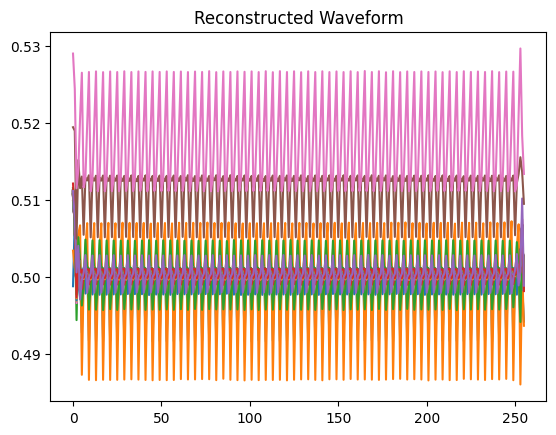

In [4]:
import matplotlib.pyplot as plt

plt.plot(source.squeeze().cpu().numpy())
plt.title("Reconstructed Waveform")
plt.show()
